In [19]:
# Import modules needed
import math # for floor()
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as sp
import matplotlib.pyplot as plt

In [20]:
# Get the data into a Pandas dataframe
csv_file = "WSF8.csv"
wsf8_df = pd.read_csv( csv_file, comment='#' )
wsf8_df

,subj.num,secs.since.peak,avg.signal,sd.signal,mean,sd,z
0,8,0.0,2.003073,0.204452,0.153964,1.222439,1.512639
1,8,0.1,0.736216,0.373815,0.153964,1.222439,0.476304
2,8,0.2,-0.260717,0.229624,0.153964,1.222439,-0.339224
3,8,0.3,-0.720213,0.182797,0.153964,1.222439,-0.715109
4,8,0.4,-0.884780,0.177141,0.153964,1.222439,-0.849731
5,8,0.5,-0.871661,0.193434,0.153964,1.222439,-0.838999
6,8,0.6,-0.846923,0.151491,0.153964,1.222439,-0.818762
7,8,0.7,-0.578307,0.218042,0.153964,1.222439,-0.599025
8,8,0.8,0.144732,0.233710,0.153964,1.222439,-0.007552
9,8,0.9,1.091171,0.255769,0.153964,1.222439,0.766670


In [21]:
# Look at all the values for just subject 8
boolIdx = np.all([(wsf8_df['subj.num'] >= 8), (wsf8_df['subj.num'] <= 8), ((wsf8_df['subj.num']%1) == 0)], axis=0)
subset_df = wsf8_df.loc[boolIdx,:].copy()
subset_df

,subj.num,secs.since.peak,avg.signal,sd.signal,mean,sd,z
0,8,0.0,2.003073,0.204452,0.153964,1.222439,1.512639
1,8,0.1,0.736216,0.373815,0.153964,1.222439,0.476304
2,8,0.2,-0.260717,0.229624,0.153964,1.222439,-0.339224
3,8,0.3,-0.720213,0.182797,0.153964,1.222439,-0.715109
4,8,0.4,-0.884780,0.177141,0.153964,1.222439,-0.849731
5,8,0.5,-0.871661,0.193434,0.153964,1.222439,-0.838999
6,8,0.6,-0.846923,0.151491,0.153964,1.222439,-0.818762
7,8,0.7,-0.578307,0.218042,0.153964,1.222439,-0.599025
8,8,0.8,0.144732,0.233710,0.153964,1.222439,-0.007552
9,8,0.9,1.091171,0.255769,0.153964,1.222439,0.766670


In [22]:
# Import the things we'll need
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [23]:
x = subset_df["secs.since.peak"]
y = 1000* subset_df["z"]
y_var = y

In [24]:
# Construct a kernel, setting an intial length and amplitude
# Ideally these should be (perhaps crudely) estimated from data
initial_ell = (np.amax(x) - np.amin(x)) / 10
initial_scale = np.var( y ) 
rbf_kernel = initial_scale * RBF(length_scale=initial_ell, 
    length_scale_bounds=(initial_ell/20, 5 * initial_ell))

# Consrtuct the GP object: note the way the uncertainty in y_train enters
gp = GaussianProcessRegressor( kernel=rbf_kernel, alpha=y_var )

In [25]:
# Fit things
x_vec = x[:, np.newaxis] # makes x into a column vector
gp.fit( x_vec, y )

# Get the fitted A and ell from the posterior
fitted_kernel = gp.kernel_
fitted_params = fitted_kernel.get_params()
A = math.sqrt( fitted_params["k1__constant_value"] )
ell = fitted_params["k2__length_scale"]

In [26]:
xVals = np.linspace( 0, 1.0)

C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:380: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


Text(0.5, 0, 'Seconds since peak')

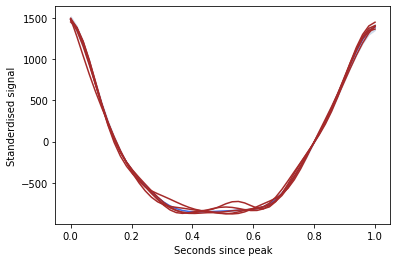

In [27]:
# Make predictions at positions listed in a vector xVals
xVal_vec = xVals[:, np.newaxis] # Build the N-by-1 array
y_mean, y_std = gp.predict(xVal_vec, return_std=True)

# Plot the mean with a +/- one std_dev shaded band
plt.plot( xVals, y_mean, color="royalblue" )
plt.fill_between(xVals, y_mean - y_std, y_mean + y_std, alpha=0.5, color="lightsteelblue" )

# Construct and plot random functions drawn from the posterior
nSamples = 5
y_samples = gp.sample_y( xVal_vec, nSamples )
plt.plot( xVals, y_samples, color="brown" )
plt.ylabel ('Standerdised signal')
plt.xlabel ('Seconds since peak')

In [28]:
# Evaluate the log likelihood at (A, ell). 
gp.log_marginal_likelihood( [math.log(A*A), math.log(ell)] )

-99.56702609616624

In [29]:
print(gp.predict)

<bound method GaussianProcessRegressor.predict of GaussianProcessRegressor(alpha=0     1512.639289
1      476.303641
2     -339.224223
3     -715.109293
4     -849.730693
5     -838.999084
6     -818.761983
7     -599.024740
8       -7.552401
9      766.669787
10    1412.785795
Name: z, dtype: float64,
                         copy_X_train=True,
                         kernel=862**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)>


Text(0.5, 0, 'Z scores for seconds since peak')

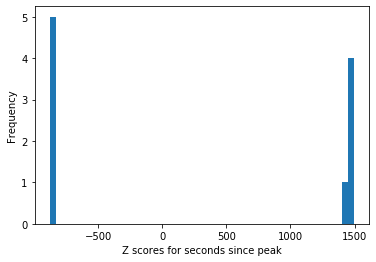

In [30]:
x = [1478.48880642, -878.30426846, 1491.2349862, -857.20725323, 1452.33746262, -876.06169614, 1496.88396785, -866.09422928, 1429.21754944, -867.59427545]
plt.hist (x, bins = 50)
plt.ylabel ('Frequency')
plt.xlabel ('Z scores for seconds since peak')